In [14]:
# import fiftyone as fo
# import fiftyone.zoo as foz

# # Download the COCO-2017 validation split and load it into FiftyOne
# dataset = foz.load_zoo_dataset("coco-2017", split="validation")

# # Give the dataset a new name, and make it persistent
# dataset.name = "coco-2017-validation"
# dataset.persistent = True


In [15]:
# dataset_train = foz.load_zoo_dataset("coco-2017", split="train")
# dataset_train.name = "coco-2017-train"
# dataset_train.persistent = True

In [16]:
# dataset_test = foz.load_zoo_dataset("coco-2017", split="test")
# dataset_test.name = "coco-2017-test"
# dataset_test.persistent = True

In [17]:
import json
import os
import numpy as np
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import cv2  # OpenCV needed for polygon drawing
from pycocotools import mask as coco_mask
from matplotlib import pyplot as plt

config = json.load(open("config.json"))

In [18]:
class CocoSegmentationDatasetMRCNN(Dataset):
    def __init__(self, image_dir, seg_annotation_file, categories_to_keep=[1], min_area_threshold=100):
        self.image_dir = image_dir
        self.coco_seg = COCO(seg_annotation_file)
        self.min_area_threshold = min_area_threshold
        self.categories_to_keep = categories_to_keep
        
        # Filter images to keep only those containing objects from specified categories
        self.image_ids = []
        for cat_id in self.categories_to_keep:
            ann_ids = self.coco_seg.getAnnIds(catIds=[cat_id], iscrowd=False)
            anns = self.coco_seg.loadAnns(ann_ids)
            valid_anns = [ann for ann in anns if ann['area'] >= self.min_area_threshold]
            img_ids = list(set([ann['image_id'] for ann in valid_anns]))
            self.image_ids.extend(img_ids)
        
        # Remove duplicates
        self.image_ids = list(set(self.image_ids))
        print(f"Dataset contains {len(self.image_ids)} images with categories {categories_to_keep}")
        
        # For visualization, create a category mapping
        self.category_map = {}
        for cat_id in self.categories_to_keep:
            cat_info = self.coco_seg.loadCats(cat_id)[0]
            self.category_map[cat_id] = cat_info['name']

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        # Load image
        image_info = self.coco_seg.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Convert to tensor
        image = transforms.ToTensor()(image)
        
        # Load annotations
        ann_ids = self.coco_seg.getAnnIds(imgIds=image_id, catIds=self.categories_to_keep, iscrowd=False)
        anns = self.coco_seg.loadAnns(ann_ids)
        
        # Initialize target dictionary
        target = {}
        boxes = []
        masks = []
        labels = []
        category_ids = []  # Keep original category IDs for reference
        
        # Process each annotation
        for ann in anns:
            if ann['area'] < self.min_area_threshold:
                continue
                
            # Get bounding box
            bbox = ann['bbox']  # [x, y, width, height] format
            # Convert to [x1, y1, x2, y2] format
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            
            # Get mask
            mask = self.coco_seg.annToMask(ann)
            masks.append(torch.as_tensor(mask, dtype=torch.uint8))
            
            # Keep original category ID for reference
            category_ids.append(ann['category_id'])
            
            # For segmentation only, use class 1 for all foreground objects
            labels.append(1)  # 1 for foreground, 0 for background
        
        # Convert to tensor format
        if boxes:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
            target["masks"] = torch.stack(masks)
            target["category_ids"] = torch.as_tensor(category_ids, dtype=torch.int64)  # original IDs for reference
        else:
            # Empty annotations
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((0), dtype=torch.int64)
            target["masks"] = torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8)
            target["category_ids"] = torch.zeros((0), dtype=torch.int64)
        
        target["image_id"] = torch.tensor([image_id])
        
        return image, target

In [25]:
# Define your categories
categories_to_keep = [3, 23, 53]  # car, bus, pizza

# Split the original training set
train_dataset_full = CocoSegmentationDatasetMRCNN(
    config["train_image_dir"],
    config["train_annotation_file"],
    categories_to_keep=categories_to_keep,
    min_area_threshold=655
)

train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

dataset_train, dataset_val = torch.utils.data.random_split(
    train_dataset_full, [train_size, val_size]
)

dataset_test = CocoSegmentationDatasetMRCNN(
    config["val_image_dir"],
    config["val_annotation_file"],
    categories_to_keep=categories_to_keep,
    min_area_threshold=655
)

# Define a proper collate function
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4,
    shuffle=False, 
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=5.72s)
creating index...
index created!
Dataset contains 11764 images with categories [3, 23, 53]
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Dataset contains 503 images with categories [3, 23, 53]


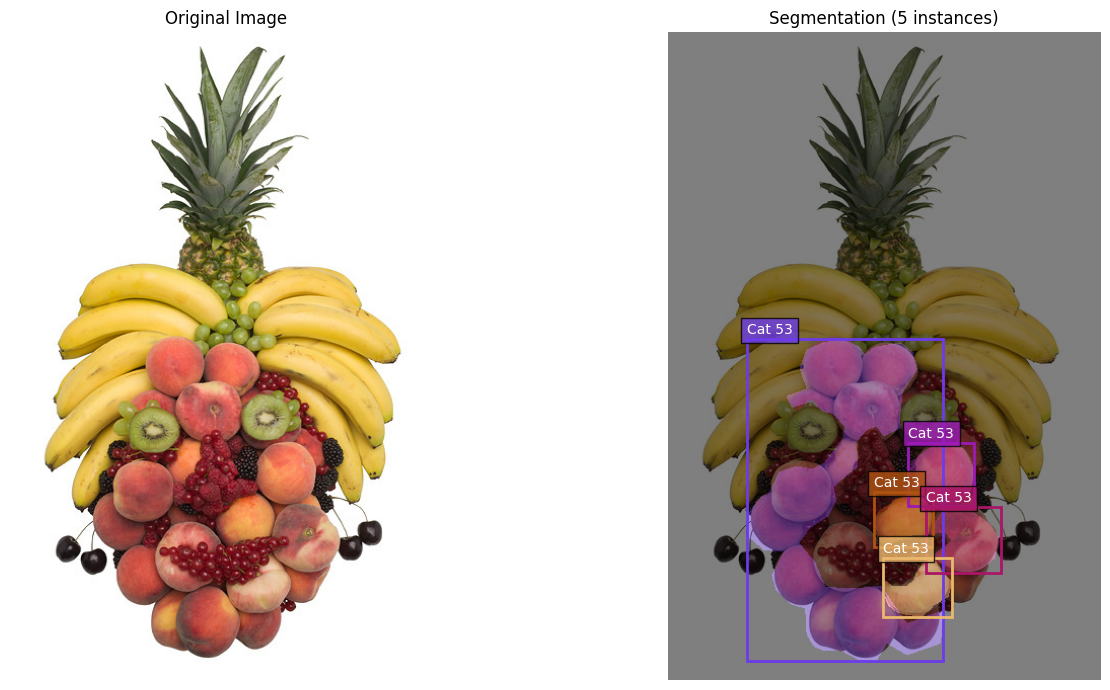

In [20]:
def visualize_bounding_boxes(dataset, idx=0):
    """Visualize an example from the dataset"""
    image, target = dataset[idx]
    
    # Convert image from tensor to numpy
    image_np = image.permute(1, 2, 0).numpy()
    
    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot original image
    ax[0].imshow(image_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Create a colored mask for visualization
    h, w = image_np.shape[:2]
    colored_mask = np.zeros((h, w, 3), dtype=np.float32)
    
    # Generate random colors for each instance
    masks = target['masks'].numpy()
    n_instances = len(masks)
    
    if n_instances > 0:
        colors = np.random.rand(n_instances, 3)
        
        # For each instance
        for i in range(n_instances):
            mask = masks[i]
            color = colors[i]
            
            # Create colored instance
            for c in range(3):
                colored_mask[:, :, c] += mask * color[c]
            
            # Draw bounding box
            if 'boxes' in target:
                box = target['boxes'][i].numpy().astype(np.int32)
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1],
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax[1].add_patch(rect)
            
            # Add category name if available
            if 'category_ids' in target:
                cat_id = target['category_ids'][i].item()
                if hasattr(dataset, 'category_map') and cat_id in dataset.category_map:
                    cat_name = dataset.category_map[cat_id]
                else:
                    cat_name = f"Cat {cat_id}"
                
                if 'boxes' in target:
                    box = target['boxes'][i].numpy().astype(np.int32)
                    ax[1].text(
                        box[0], box[1] - 5, cat_name,
                        color='white', fontsize=10, bbox=dict(facecolor=color, alpha=0.8)
                    )
    
    # Normalize the colored mask
    if n_instances > 0:
        max_val = np.max(colored_mask)
        if max_val > 0:
            colored_mask = colored_mask / max_val
    
    # Blend with original image
    alpha = 0.5
    composite = image_np * (1 - alpha) + colored_mask * alpha
    
    # Show result
    ax[1].imshow(composite)
    ax[1].set_title(f'Segmentation ({n_instances} instances)')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_bounding_boxes(dataset_train, idx=4)
    

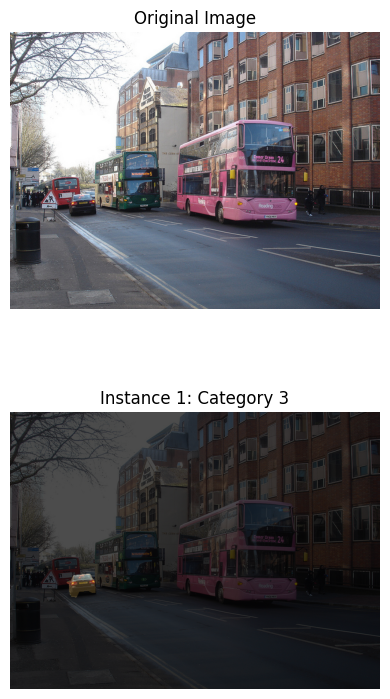

In [21]:
def visualize_individual_masks(dataset, idx=0):
    """Visualize individual instance masks from the dataset"""
    image, target = dataset[idx]
    
    # Convert image from tensor to numpy
    image_np = image.permute(1, 2, 0).numpy()
    
    # Get masks
    masks = target['masks'].numpy()
    
    # Get category IDs if available
    if 'category_ids' in target:
        category_ids = target['category_ids'].numpy()
        has_categories = True
    else:
        has_categories = False
    
    n_instances = len(masks)
    
    if n_instances == 0:
        print("No instances found in this image")
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        return
    
    # Calculate grid size
    n_cols = min(3, n_instances)
    n_rows = (n_instances + n_cols - 1) // n_cols
    
    # Create figure - original image + individual masks
    fig = plt.figure(figsize=(4*n_cols, 4*(n_rows+1)))
    
    # Show original image
    ax = fig.add_subplot(n_rows+1, 1, 1)
    ax.imshow(image_np)
    ax.set_title('Original Image')
    ax.axis('off')
    
    # Show each instance mask
    for i in range(n_instances):
        ax = fig.add_subplot(n_rows+1, n_cols, n_cols+i+1)
        
        # Get mask
        mask = masks[i]
        
        # Create a colored version for better visibility
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
        color = np.random.rand(3)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        
        # Show mask overlaid on image
        overlay = image_np * 0.7 + colored_mask * 0.3
        
        # Only show mask area
        mask_area = mask > 0
        overlay = np.where(np.repeat(mask_area[:, :, np.newaxis], 3, axis=2), 
                          overlay, 
                          image_np * 0.3)  # Dim non-mask area
        
        ax.imshow(overlay)
        
        # Show category if available
        if has_categories:
            cat_id = category_ids[i]
            if hasattr(dataset, 'category_map') and cat_id in dataset.category_map:
                cat_name = dataset.category_map[cat_id]
            else:
                cat_name = f"Category {cat_id}"
            ax.set_title(f'Instance {i+1}: {cat_name}')
        else:
            ax.set_title(f'Instance {i+1}')
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_individual_masks(dataset_train, idx=0) 

# Train 

In [26]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Get number of input features for mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # Replace mask predictor with new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)
    
    return model

In [27]:
import torch
import time

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    print(f"Training loss: {total_loss/len(data_loader):.4f}")
    
    return total_loss/len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    
    print(f"Validation loss: {total_loss/len(data_loader):.4f}")
    return total_loss/len(data_loader)

In [ ]:
def train_model(data_loader_train, data_loader_val, num_classes):
    # Setup device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # Define number of classes (background + your categories)
    num_classes = num_classes + 1  # +1 for background
    
    # Get the model
    model = get_model_instance_segmentation(num_classes)
    model.to(device)
    
    # Define optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    # Learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Number of epochs
    num_epochs = 10
    
    # Training loop
    best_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss = train_one_epoch(model, optimizer, data_loader_train, device)
        
        # Update learning rate
        lr_scheduler.step()
        
        # Evaluate
        val_loss = evaluate(model, data_loader_val, device)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'models/best_maskrcnn_model.pth')
            print(f"Saved best model with validation loss: {best_loss:.4f}")
    
    print("Training complete!")
    return model

# Run the training
model = train_model(data_loader_train, data_loader_val, num_classes=len(categories_to_keep))

Epoch 1/10


In [ ]:
from torchvision.utils import draw_segmentation_masks
import torchvision.ops as ops

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def calculate_ap(model, data_loader, device, iou_threshold=0.5):
    """Calculate Average Precision on the test data"""
    model.eval()
    
    all_gt_boxes = []
    all_gt_labels = []
    all_gt_masks = []
    all_pred_boxes = []
    all_pred_labels = []
    all_pred_scores = []
    all_pred_masks = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            
            # Save ground truth for this batch
            for target in targets:
                all_gt_boxes.append(target['boxes'].cpu())
                all_gt_labels.append(target['labels'].cpu())
                all_gt_masks.append(target['masks'].cpu())
            
            # Run inference
            outputs = model(images)
            
            # Save predictions for this batch
            for output in outputs:
                all_pred_boxes.append(output['boxes'].cpu())
                all_pred_labels.append(output['labels'].cpu())
                all_pred_scores.append(output['scores'].cpu())
                all_pred_masks.append(output['masks'].cpu() > 0.5)  # Threshold at 0.5
    
    # Calculate AP for each class
    ap_per_class = {}
    for class_id in range(1, model.roi_heads.box_predictor.cls_score.out_features):  # Skip background (0)
        true_positives = 0
        false_positives = 0
        total_gt = 0
        
        # Count total ground truth for this class
        for gt_labels in all_gt_labels:
            total_gt += (gt_labels == class_id).sum().item()
        
        if total_gt == 0:
            ap_per_class[class_id] = float('nan')  # No ground truth for this class
            continue
        
        # Collect all predictions for this class
        all_class_scores = []
        all_class_matched = []
        
        for i in range(len(all_pred_boxes)):
            pred_boxes = all_pred_boxes[i]
            pred_labels = all_pred_labels[i]
            pred_scores = all_pred_scores[i]
            pred_masks = all_pred_masks[i]
            
            gt_boxes = all_gt_boxes[i]
            gt_labels = all_gt_labels[i]
            gt_masks = all_gt_masks[i]
            
            # Find predictions of this class
            class_indices = (pred_labels == class_id).nonzero().flatten()
            
            # Get GT instances of this class
            gt_class_indices = (gt_labels == class_id).nonzero().flatten()
            
            # Mark GT as already matched or not
            gt_matched = [False] * len(gt_class_indices)
            
            # For each prediction of this class
            for idx in class_indices:
                pred_box = pred_boxes[idx].unsqueeze(0)
                pred_score = pred_scores[idx].item()
                pred_mask = pred_masks[idx]
                
                all_class_scores.append(pred_score)
                
                # Check if matches any GT
                if len(gt_class_indices) == 0:
                    # No GT, so it's a false positive
                    all_class_matched.append(0)
                    continue
                
                # Calculate IoU with GT masks
                max_iou = 0
                max_idx = -1
                
                for j, gt_idx in enumerate(gt_class_indices):
                    if gt_matched[j]:
                        continue
                    
                    gt_mask = gt_masks[gt_idx]
                    
                    # Calculate mask IoU
                    intersection = (pred_mask & gt_mask).sum().float()
                    union = (pred_mask | gt_mask).sum().float()
                    iou = intersection / union if union > 0 else 0
                    
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = j
                
                # Check if IoU is above threshold
                if max_iou >= iou_threshold and max_idx >= 0:
                    gt_matched[max_idx] = True
                    all_class_matched.append(1)  # True positive
                else:
                    all_class_matched.append(0)  # False positive
        
        # Sort by confidence score
        if all_class_scores:
            scores_and_matched = list(zip(all_class_scores, all_class_matched))
            scores_and_matched.sort(key=lambda x: x[0], reverse=True)
            all_class_matched = [x[1] for x in scores_and_matched]
            
            # Calculate precision and recall
            precisions = []
            recalls = []
            tp_count = 0
            fp_count = 0
            
            for matched in all_class_matched:
                if matched:
                    tp_count += 1
                else:
                    fp_count += 1
                
                precision = tp_count / (tp_count + fp_count)
                recall = tp_count / total_gt
                
                precisions.append(precision)
                recalls.append(recall)
            
            # Calculate AP using the 11-point interpolation
            ap = 0
            for t in range(11):  # 11 points: 0, 0.1, 0.2, ..., 1.0
                recall_threshold = t / 10
                max_precision = 0
                
                for i in range(len(recalls)):
                    if recalls[i] >= recall_threshold:
                        max_precision = max(max_precision, precisions[i])
                
                ap += max_precision / 11
            
            ap_per_class[class_id] = ap
        else:
            ap_per_class[class_id] = 0.0
    
    # Calculate mAP
    valid_aps = [ap for ap in ap_per_class.values() if not np.isnan(ap)]
    mAP = sum(valid_aps) / len(valid_aps) if valid_aps else 0
    
    return mAP, ap_per_class

# To use:
mAP, ap_per_class = calculate_ap(model, data_loader_test, device)
print(f"Mean Average Precision (mAP): {mAP:.4f}")
print("AP per class:")
for class_id, ap in ap_per_class.items():
    print(f"Class {class_id}: {ap:.4f}")

In [ ]:
def get_prediction(model, image_tensor, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]
    
    # Filter predictions based on score
    keep = prediction['scores'] > threshold
    
    filtered_prediction = {
        'boxes': prediction['boxes'][keep],
        'labels': prediction['labels'][keep],
        'scores': prediction['scores'][keep],
        'masks': prediction['masks'][keep]
    }
    
    return filtered_prediction

def visualize_prediction(image, prediction, dataset):
    """Visualize model prediction"""
    # Convert image to numpy
    image_np = image.permute(1, 2, 0).numpy()
    
    # Get components
    masks = prediction['masks'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax[0].imshow(image_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Prediction
    ax[1].imshow(image_np * 0.5)  # Dim the original image
    ax[1].set_title('Predicted Masks')
    ax[1].axis('off')
    
    # Generate random colors
    n_instances = len(masks)
    colors = np.random.rand(n_instances, 3)
    
    # Draw each mask
    for i in range(n_instances):
        # Get mask (first channel, threshold at 0.5)
        mask = masks[i, 0] > 0.5
        color = colors[i]
        
        # Create colored mask
        colored_mask = np.zeros_like(image_np)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        
        # Overlay on image
        mask_area = mask > 0
        masked_img = np.where(np.repeat(mask_area[:, :, np.newaxis], 3, axis=2),
                            image_np * 0.7 + colored_mask * 0.3,
                            ax[1].get_array() * 0.7)
        ax[1].imshow(masked_img)
        
        # Add label info if available
        label_id = labels[i]
        if hasattr(dataset, 'category_map') and label_id in dataset.category_map:
            label_name = dataset.category_map[label_id]
        else:
            label_name = f"Class {label_id}"
        
        # Find center of mass for text placement
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_center = int(np.mean(x_indices))
            y_center = int(np.mean(y_indices))
            
            # Add label text
            ax[1].text(x_center, y_center, 
                      f"{label_name}: {scores[i]:.2f}",
                      color='white', fontsize=8, 
                      ha='center', va='center',
                      bbox=dict(facecolor=color, alpha=0.7, pad=1))
    
    plt.tight_layout()
    plt.show()

# Test on a validation image
with torch.no_grad():
    # Get an image from validation set
    image, _ = dataset_val[0]
    
    # Get prediction
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    prediction = get_prediction(model, image, device, threshold=0.7)
    
    # Visualize
    visualize_prediction(image, prediction, dataset_val)